Problem Statement¶
Spam messages are unwanted and often harmful messages sent in bulk.
The goal of this project is to build a machine learning model that can automatically classify SMS messages as Spam or Ham (Not Spam) using Natural Language Processing techniques.

2. Data Understanding
The SMS Spam Collection dataset contains SMS messages labeled as:

Ham – normal messages
Spam – unwanted promotional/fraud messages

In [2]:
import pandas as pd

df = pd.read_csv("../data/spam.csv",encoding =  'latin-1')

df = df[['v1','v2']]
df.columns = ['label','message']

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape,df.dtypes

((5572, 2),
 label      object
 message    object
 dtype: object)

In [4]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
df.describe(include = 'all')

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
df.isnull().sum()

label      0
message    0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(403)

In [8]:
df['label'] = df['label'].map({'ham':0,"spam":1})
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
from sklearn.model_selection import train_test_split

X = df['message']
y = df['label']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

Data Preprocessing

Using TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

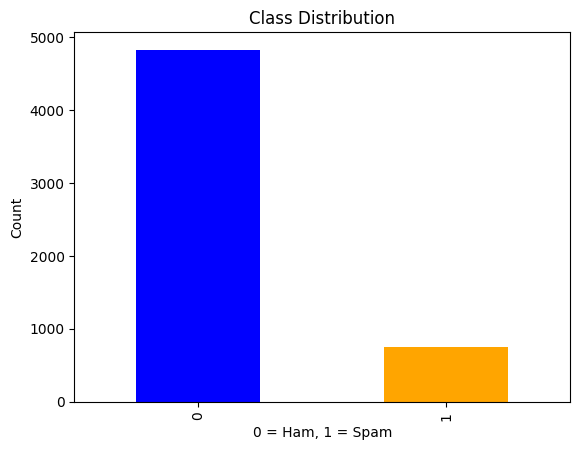

In [11]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar',color = ['blue','orange'])
plt.xlabel('0 = Ham, 1 = Spam')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [12]:
df['length'] = df['message'].apply(len)
df.groupby('label')['length'].mean()

label
0     71.023627
1    138.866131
Name: length, dtype: float64

In [13]:
df

,label,message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161
5568,0,Will Ì_ b going to esplanade fr home?,37
5569,0,"Pity, * was in mood for that. So...any other s...",57
5570,0,The guy did some bitching but I acted like i'd...,125


Model Selection


1.Naive Bayes

2.Logistic Regression

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

nb = MultinomialNB()
nb = nb.fit(X_train_tfidf,y_train)

y_pred = nb.predict(X_test_tfidf)
accuracy = accuracy_score(y_test,y_pred)

print(f'Accuracy: {accuracy*100:.2f}%')
print('\nClassification Report:\n',classification_report(y_test,y_pred))

Accuracy: 96.05%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       957
           1       1.00      0.72      0.84       158

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [15]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression()   

lr.fit(X_train_tfidf,y_train)

y_pred = lr.predict(X_test_tfidf)   

print(f'Accuracy: {accuracy_score(y_test,y_pred)*100:.2f}%')
print('\nClassification Report:\n',classification_report(y_test,y_pred))

Accuracy: 95.61%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       957
           1       1.00      0.69      0.82       158

    accuracy                           0.96      1115
   macro avg       0.98      0.84      0.90      1115
weighted avg       0.96      0.96      0.95      1115



In [16]:
def predict_spam(message):
    message_tfidf = tfidf.transform([message])
    result = lr.predict(message_tfidf)
    return "Spam" if result[0] == 1 else "Ham"

predict_spam("Congratulations! You have won a free prize")

'Spam'

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']
}




In [18]:
lr = LogisticRegression(max_iter=1000)

grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_lr.fit(X_train_tfidf, y_train)


,estimator,LogisticRegre...max_iter=1000)
,param_grid,"{'C': [0.01, 0.1, ...], 'class_weight': [None, 'balanced']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [19]:
print("Best Parameters:", grid_lr.best_params_)
print("Best CV F1-score:", grid_lr.best_score_)


Best Parameters: {'C': 100, 'class_weight': 'balanced'}
Best CV F1-score: 0.9298475568247915


In [20]:
best_lr = grid_lr.best_estimator_

y_pred_lr = best_lr.predict(X_test_tfidf)

print("Tuned Logistic Regression Accuracy:",
      accuracy_score(y_test, y_pred_lr))

print("\nClassification Report:\n",
      classification_report(y_test, y_pred_lr))

Tuned Logistic Regression Accuracy: 0.9802690582959641

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       957
           1       0.97      0.89      0.93       158

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [24]:
import pickle 

with open("../models/spam_model.pkl","wb") as f:
    pickle.dump(best_lr,f)

with open("../models/tfidf_vectorizer.pkl","wb") as f:
    pickle.dump(tfidf,f)